In [6]:
import scipy

In [4]:
import numpy as np
from scipy.optimize import root_scalar, root, minimize, Bounds, LinearConstraint, NonlinearConstraint, dual_annealing
from scipy.integrate import fixed_quad
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit

## Solve linear equation system

$$
\underset{A}{\underbrace{\left[\begin{array}{ccc}
1 & 2 & 3\\
2 & 1 & 0\\
4 & 2 & 1
\end{array}\right]}}x=\underset{b}{\underbrace{\left[\begin{array}{c}
1\\
0\\
3
\end{array}\right]}}
$$

In [2]:
A = np.array([[1, 2, 3],
              [2, 1, 0],
              [4, 2, 1]])

b = np.array([[1, 0, 3]]).T

# alternatively
# b = np.array([[1],
#               [0],
#               [3]])

# the wrong way, one dimensional array
# b = np.array([1, 0, 3]).T

$$
x=A^{-1}b
$$

`numpy.linalg`: https://numpy.org/doc/stable/reference/routines.linalg.html

In [3]:
# np.linalg.inv?

In [4]:
x = np.linalg.inv(A) @ b

x

array([[ 2.66666667],
       [-5.33333333],
       [ 3.        ]])

In [5]:
A @ x - b

array([[0.],
       [0.],
       [0.]])

In [6]:
np.dot(A, x) - b

array([[0.],
       [0.],
       [0.]])

In [7]:
# np.linalg.solve?

In [8]:
np.linalg.solve(A, b)

array([[ 2.66666667],
       [-5.33333333],
       [ 3.        ]])

In [9]:
qe.tic()
np.linalg.inv(A) @ b
qe.toc()

TOC: Elapsed: 0:00:0.00


0.00031828880310058594

In [10]:
qe.tic()
np.linalg.solve(A, b)
qe.toc()

TOC: Elapsed: 0:00:0.00


0.0007255077362060547

In [12]:
np.random.seed(1234)

N = 1000
A_large = np.random.random((N, N))
b_large = np.random.random((N, 1))

A_large.shape, b_large.shape

((1000, 1000), (1000, 1))

In [12]:
np.linalg.matrix_rank(A_large)

1000

In [13]:
np.max(np.abs(np.linalg.inv(A_large) @ b_large - np.linalg.solve(A_large, b_large)))

1.7304907506954237e-13

In [14]:
qe.tic()
np.linalg.inv(A_large) @ b_large
qe.toc()

TOC: Elapsed: 0:00:0.22


0.2215886116027832

In [15]:
qe.tic()
np.linalg.solve(A_large, b_large)
qe.toc()

TOC: Elapsed: 0:00:0.55


0.5505948066711426

## Solve nonlinear equation system

In [13]:
@njit
def f_root(x, ϕ0, ϕ1, ϕ2):

    return ϕ0 + ϕ1 * x + ϕ2 * x**2

In [14]:
ϕ0, ϕ1, ϕ2 = 1., 0.3, -0.07

In [18]:
x_range = np.linspace(-5, 10, 100)

x_range

array([-5.        , -4.84848485, -4.6969697 , -4.54545455, -4.39393939,
       -4.24242424, -4.09090909, -3.93939394, -3.78787879, -3.63636364,
       -3.48484848, -3.33333333, -3.18181818, -3.03030303, -2.87878788,
       -2.72727273, -2.57575758, -2.42424242, -2.27272727, -2.12121212,
       -1.96969697, -1.81818182, -1.66666667, -1.51515152, -1.36363636,
       -1.21212121, -1.06060606, -0.90909091, -0.75757576, -0.60606061,
       -0.45454545, -0.3030303 , -0.15151515,  0.        ,  0.15151515,
        0.3030303 ,  0.45454545,  0.60606061,  0.75757576,  0.90909091,
        1.06060606,  1.21212121,  1.36363636,  1.51515152,  1.66666667,
        1.81818182,  1.96969697,  2.12121212,  2.27272727,  2.42424242,
        2.57575758,  2.72727273,  2.87878788,  3.03030303,  3.18181818,
        3.33333333,  3.48484848,  3.63636364,  3.78787879,  3.93939394,
        4.09090909,  4.24242424,  4.39393939,  4.54545455,  4.6969697 ,
        4.84848485,  5.        ,  5.15151515,  5.3030303 ,  5.45

In [19]:
y = f_root(x_range, ϕ0, ϕ1, ϕ2)

y

array([-2.25      , -2.10009183, -1.95339761, -1.80991736, -1.66965106,
       -1.53259871, -1.39876033, -1.2681359 , -1.14072544, -1.01652893,
       -0.89554637, -0.77777778, -0.66322314, -0.55188246, -0.44375574,
       -0.33884298, -0.23714417, -0.13865932, -0.04338843,  0.0486685 ,
        0.13751148,  0.2231405 ,  0.30555556,  0.38475666,  0.4607438 ,
        0.53351699,  0.60307622,  0.66942149,  0.7325528 ,  0.79247016,
        0.84917355,  0.90266299,  0.95293848,  1.        ,  1.04384757,
        1.08448118,  1.12190083,  1.15610652,  1.18709826,  1.21487603,
        1.23943985,  1.26078972,  1.27892562,  1.29384757,  1.30555556,
        1.31404959,  1.31932966,  1.32139578,  1.32024793,  1.31588613,
        1.30831038,  1.29752066,  1.28351699,  1.26629936,  1.24586777,
        1.22222222,  1.19536272,  1.16528926,  1.13200184,  1.09550046,
        1.05578512,  1.01285583,  0.96671258,  0.91735537,  0.86478421,
        0.80899908,  0.75      ,  0.68778696,  0.62235996,  0.55

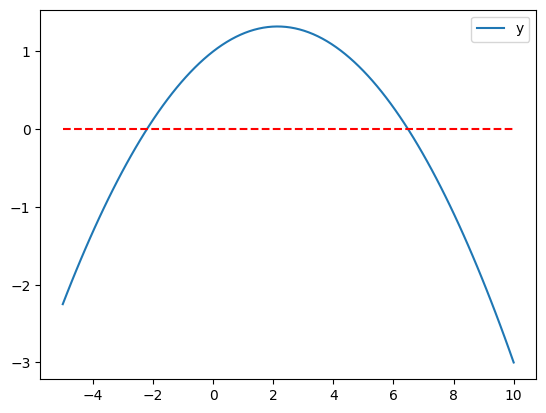

In [20]:
plt.plot(x_range, y, label='y')
plt.hlines(0, -5, 10, colors='r', linestyles='--')
plt.legend()

Two sources of root finding and optimizing routines:

1. `quantecon.optimize`: jitted, suitable for finding optimal continuous choice for each household. https://quanteconpy.readthedocs.io/en/latest/optimize.html
2. `scipy.optimize`: nonjitted, suitable for estimation routines, such as SMM or MLE. https://docs.scipy.org/doc/scipy/reference/optimize.html

### quantecon

In [21]:
qe.optimize.bisect?

In [22]:
res = qe.optimize.bisect(f_root, -4, 0, args=(ϕ0, ϕ1, ϕ2))

res

results(root=-2.201973235927653, function_calls=43, iterations=41, converged=True)

In [23]:
res.root

-2.201973235927653

In [24]:
qe.optimize.bisect(f_root, 8, 0, args=(ϕ0, ϕ1, ϕ2))

results(root=6.487687521641419, function_calls=44, iterations=42, converged=True)

Brent's Method: a hybrid root-finding algorithm combining the bisection method, the secant method and inverse quadratic interpolation

In [25]:
qe.optimize.brentq(f_root, -4, 0, args=(ϕ0, ϕ1, ϕ2))

results(root=-2.201973235927299, function_calls=9, iterations=8, converged=True)

In [26]:
qe.optimize.brentq(f_root, 4, 8, args=(ϕ0, ϕ1, ϕ2))

results(root=6.487687521641584, function_calls=9, iterations=8, converged=True)

In [27]:
@njit
def f_prime(x, ϕ0, ϕ1, ϕ2):

    return ϕ1 + 2 * ϕ2 * x

In [28]:
qe.optimize.newton(f_root, -4, f_prime, args=(ϕ0, ϕ1, ϕ2))

results(root=-2.2019732359272997, function_calls=10, iterations=5, converged=True)

In [29]:
qe.optimize.newton(f_root, 8, f_prime, args=(ϕ0, ϕ1, ϕ2))

results(root=6.487687521641585, function_calls=10, iterations=5, converged=True)

In [30]:
qe.optimize.newton_secant(f_root, -4, args=(ϕ0, ϕ1, ϕ2))

results(root=-2.2019732359273005, function_calls=7, iterations=6, converged=True)

In [31]:
qe.optimize.newton_secant(f_root, 8, args=(ϕ0, ϕ1, ϕ2))

results(root=6.487687521641585, function_calls=7, iterations=6, converged=True)

### scipy

In [32]:
root_scalar(f_root, x0=-4, args=(ϕ0, ϕ1, ϕ2), method='secant')

      converged: True
           flag: converged
 function_calls: 7
     iterations: 6
           root: -2.2019732359273005
         method: secant

In [33]:
@njit
def call_root_finding_qe(f, x0, args):
    res = qe.optimize.newton_secant(f_root, x0, args=args)
    return res

In [34]:
call_root_finding_qe(f_root, -4, (ϕ0, ϕ1, ϕ2))

results(root=-2.2019732359273005, function_calls=7, iterations=6, converged=True)

In [35]:
@njit
def call_root_finding_sp(f, x0, args):
    res = root_scalar(f_root, x0=x0, args=args, method='secant')
    return res

In [36]:
call_root_finding_sp(f_root, -4, (ϕ0, ϕ1, ϕ2))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'root_scalar':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "../../tmp/ipykernel_812/633488042.py", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

### multivariate function

In [37]:
@njit
def func(x, a, b, c, d):

    #     return (x[0] - a) ** b + (x[1] - c) ** d
    x1, x2 = x
    return (x1 - a) ** b + (x2 - c) ** d

In [38]:
a, b, c, d = 0.1, 2, -0.5, 2

Root will be $\left[a, c\right]=\left[0.1, -0.5\right]$

In [39]:
root_scalar(func, x0=np.array([0., -0.]), args=(a, b, c, d), method='secant')

RuntimeError: all failed to converge after 50 iterations

In [40]:
root_scalar(func, x0=np.array([0.099, -0.499]), args=(a, b, c, d), method='secant')

RuntimeError: all failed to converge after 50 iterations

In [41]:
func(np.array([0.099, -0.499]), a, b, c, d)

2.0000000000000037e-06

In [42]:
func_sq = njit(lambda x, a, b, c, d: func(x, a, b, c, d) ** 2)
res = minimize(func_sq, x0=np.array([0., 0.]), args=(a, b, c, d), method='BFGS')

res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.3540513933167419e-08
        x: [ 1.021e-01 -5.106e-01]
      nit: 5
      jac: [ 9.847e-07 -4.923e-06]
 hess_inv: [[ 1.280e+01 -5.899e+01]
            [-5.899e+01  2.959e+02]]
     nfev: 24
     njev: 8

In [43]:
res.x

array([ 0.10211553, -0.51057772])

### Vector-valued function

In [44]:
@njit
def func_vec(x):
    return [x[0]  + 0.5 * (x[0] - x[1])**3 - 1.0,
            0.5 * (x[1] - x[0])**3 + x[1]]

In [45]:
res = root(func_vec, x0=np.array([0, 0]), method='broyden1')

res

 message: A solution was found at the specified tolerance.
 success: True
  status: 1
     fun: [-1.200e-07  4.892e-07]
       x: [ 8.412e-01  1.588e-01]
     nit: 14
  method: broyden1

## Optimization

In [46]:
minimize(func_sq, x0=np.array([0., 0.]), args=(a, b, c, d), method='nelder-mead')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.7907191143434604e-18
             x: [ 9.996e-02 -5.000e-01]
           nit: 58
          nfev: 116
 final_simplex: (array([[ 9.996e-02, -5.000e-01],
                       [ 9.997e-02, -5.000e-01],
                       [ 1.000e-01, -4.999e-01]]), array([ 2.791e-18,  5.351e-18,  3.686e-17]))

### Constrainted optimization

Bounds:

$$
lb\leq x\leq ub
$$

In [47]:
bounds = np.array([[-5, 5],         # for x1
                   [-0.3, np.inf]]) # for x2

In [48]:
res = minimize(func_sq, x0=np.array([0., 0.]),
               args=(a, b, c, d), bounds=bounds,
               method='nelder-mead')

res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0016000000573483334
             x: [ 1.000e-01 -3.000e-01]
           nit: 44
          nfev: 82
 final_simplex: (array([[ 1.000e-01, -3.000e-01],
                       [ 1.000e-01, -3.000e-01],
                       [ 9.994e-02, -3.000e-01]]), array([ 1.600e-03,  1.600e-03,  1.600e-03]))

Linear contraints:

$$
lb\leq A\cdot x\leq ub
$$

Nonlinear constraints:

$$
lb\leq f\left(x\right)\leq ub
$$

In [49]:
A_lc = np.array([[0., 0.2]])

@njit
def f_nc(x):
    return np.sum(x ** 2)

In [50]:
A_lc @ res.x

array([-0.06])

In [51]:
f_nc(res.x)

0.10000535554319574

In [52]:
lc = LinearConstraint(A_lc, lb=np.array([0.2]), ub=np.array([5.]))

In [53]:
res = minimize(func_sq, x0=np.array([0., 0.]), args=(a, b, c, d),
               bounds=bounds, constraints=(lc), method='SLSQP')

res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5.062500001305947
       x: [ 9.998e-02  1.000e+00]
     nit: 9
     jac: [-1.533e-04  1.350e+01]
    nfev: 32
    njev: 9

In [54]:
A_lc @ res.x

array([0.2])

In [55]:
f_nc(res.x)

1.0099965931816266

In [56]:
nc = NonlinearConstraint(f_nc, lb=np.array([2.]), ub=np.array([10.]))

In [57]:
res = minimize(func_sq, x0=np.array([0., 0.]), args=(a, b, c, d),
               bounds=bounds, constraints=(lc, nc), method='SLSQP')

res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.36360000150657
       x: [ 1.000e+00  1.000e+00]
     nit: 9
     jac: [ 1.102e+01  1.836e+01]
    nfev: 27
    njev: 9

In [58]:
f_nc(res.x)

2.0000000002736176

In [59]:
A_lc @ res.x

array([0.2])

### Global optimization

`dual_annealing`: simulated annealing + local minimizer of your choice (optional)

In [60]:
bounds = np.array([[-5, 5],
                   [-0.3, np.inf]])

dual_annealing(func_sq, bounds, args=(a, b, c, d),
               minimizer_kwargs={'method': 'nelder-mead'},
               no_local_search=False)

ValueError: Some bounds values are inf values or nan values

In [61]:
bounds = np.array([[-5, 5],
                   [-10., 10.]])

dual_annealing(func_sq, bounds, args=(a, b, c, d),
               minimizer_kwargs={'method': 'nelder-mead'},
               no_local_search=False)

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 2.5326563028959785e-19
       x: [ 1.000e-01 -5.000e-01]
     nit: 1000
    nfev: 4087
    njev: 0
    nhev: 0

## Quadrature

To compute

$$
\int_{-\infty}^{\infty} f\left(x\right) dx
$$

where $x\sim N\left(0, 1\right)$

It can be approximated by

$$
\sum_{i=1}^{n}\frac{\omega_{i}}{\sqrt{\pi}}f\left(\mu+\sqrt{2}\sigma\zeta_{i}\right)
$$

using Guass-Hermite approximation

In [62]:
μ = 0
σ = 1

In [63]:
@njit
def f_integrand(x, λ0, λ1, λ2):

    return λ0 + λ1 * x + λ2 * x**2

@njit
def quad(f, args, μ, σ, nodes, weights):

    integral = np.sum(weights / np.sqrt(np.pi) *
                      f_integrand(μ + np.sqrt(2) * σ * nodes, *args))

    return integral

In [64]:
λ0, λ1, λ2 = 0.5, 0.2, 0.3

In [65]:
# Gaussian-Hermite quadrature nodes and weights for order 5
ζ_nodes5 = np.array([0,
                     0.958572464613819,
                     -0.958572464613819,
                     0.202018287045609,
                     -0.202018287045609])

ω_weights5 = np.array([0.945308720482942,
                       0.393619323152241,
                       0.393619323152241,
                       0.0199532420590459,
                       0.0199532420590459])

In [66]:
quad(f_integrand, (λ0, λ1, λ2), μ, σ, ζ_nodes5, ω_weights5)

0.7454196465070009

In [67]:
# Gaussian-Hermite quadrature nodes and weights for order 10
ζ_nodes10 = np.array([0.342901327223704609,
                      -0.342901327223704609,
                      1.03661082978951365,
                      -1.03661082978951365,
                      1.75668364929988177,
                      -1.75668364929988177,
                      2.53273167423278980,
                      -2.53273167423278980,
                      3.43615911883773760,
                      -3.43615911883773760])

ω_weights10 = np.array([0.610862633735325799,
                        0.610862633735325799,
                        0.240138611082314686,
                        0.240138611082314686,
                        0.0338743944554810631,
                        0.0338743944554810631,
                        0.00134364574678123269,
                        0.00134364574678123269,
                        0.764043285523262063e-5,
                        0.764043285523262063e-5])

In [68]:
quad(f_integrand, (λ0, λ1, λ2), μ, σ, ζ_nodes10, ω_weights10)

0.8

## Simulation based integration

`numpy.random`: random sampling, https://numpy.org/doc/stable/reference/random/index.html#module-numpy.random

In [69]:
np.random.normal?

In [70]:
np.random.seed(1234)
x_normal = np.random.normal(size=10000, loc=0, scale=1)

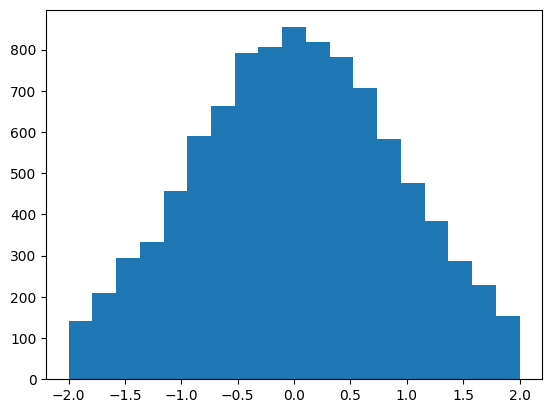

In [71]:
plt.hist(x_normal, bins=np.linspace(-2, 2, 20));

In [72]:
f_integrand(x_normal, λ0, λ1, λ2).mean()

0.8004182241729138

## Cubic spline interpolation

`scipy.interpolate`: https://docs.scipy.org/doc/scipy/reference/interpolate.html

In [73]:
x = np.arange(10)
y = np.sin(x)

In [74]:
cs = CubicSpline(x, y)

cs

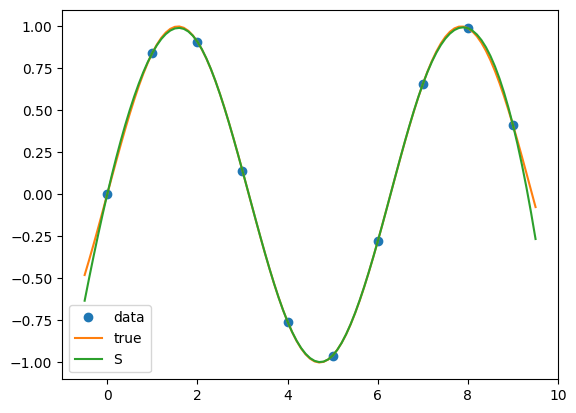

In [75]:
fig = plt.figure()

xs = np.arange(-0.5, 9.6, 0.1)

plt.plot(x, y, 'o', label='data')
plt.plot(xs, np.sin(xs), label='true')
plt.plot(xs, cs(xs), label="S")

plt.legend()

## Two Period Job Search Model

In [76]:
from quantecon.distributions import BetaBinomial

import numpy as np
from numba import njit
from collections import namedtuple

In [77]:
BetaBinomial?

In [78]:
namedtuple?

In [79]:
# NamedTuple Model
Model = namedtuple("Model", ("n", "w_vals", "φ", "β", "c"))

In [80]:
def create_job_search_model(
        n=50,        # wage grid size
        w_min=10.0,  # lowest wage
        w_max=60.0,  # highest wage
        a=200,       # wage distribution parameter
        b=100,       # wage distribution parameter
        β=0.96,      # discount factor
        c=10.0       # unemployment compensation
    ):
    """
    Creates the parameters for job search model and returns the
    instance of namedtuple Model
    """
    w_vals = np.linspace(w_min, w_max, n+1)
    φ = BetaBinomial(n, a, b).pdf()
    return Model(n=n, w_vals=w_vals, φ=φ, β=β, c=c)

In [81]:
model = create_job_search_model()

In [82]:
n, w_vals, φ, β, c = model

In [83]:
w_vals.size

51

In [84]:
w_vals

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60.])

In [85]:
φ.size

51

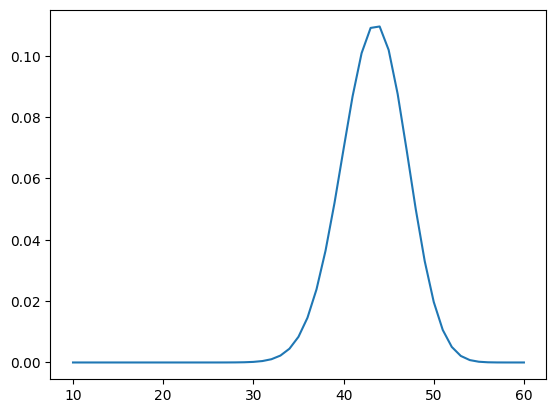

In [86]:
plt.plot(w_vals, φ);

In [87]:
φ.sum()

1.0000000000002227

$$
v_{1}\left(w_{1}\right)	=\max\left\{ w_{1}+\beta w_{1},c+\beta\sum_{w^{\prime}\in W}v_{2}\left(w^{\prime}\right)\varphi\left(w^{\prime}\right)\right\} 
	=\max\left\{ w_{1}+\beta w_{1},h_{1}\right\} \\
v_{2}\left(w\right)=\max\left\{ c,w\right\} \\
$$

In [88]:
@njit
def v_1(w, model):
    """
    Computes lifetime value at t=1 given current wage w_1 = w
    """
    β, c = model.β, model.c
    s = np.maximum(c, model.w_vals)           # which is v2
    h_1 = c + β * np.sum(s * model.φ)
    return np.maximum(w + β * w, h_1)

$$
w_{1}^{*}:=\frac{h_{1}}{1+\beta}
$$

In [89]:
@njit
def res_wage(model):
    """
    Computes reservation wage at t=1
    """
    β, c = model.β, model.c
    s = np.maximum(c, model.w_vals)
    h_1 = c + β * np.sum(s * model.φ)
    return h_1 / (1 + β)

In [90]:
w_star = res_wage(model)

w_star

26.326530612249694

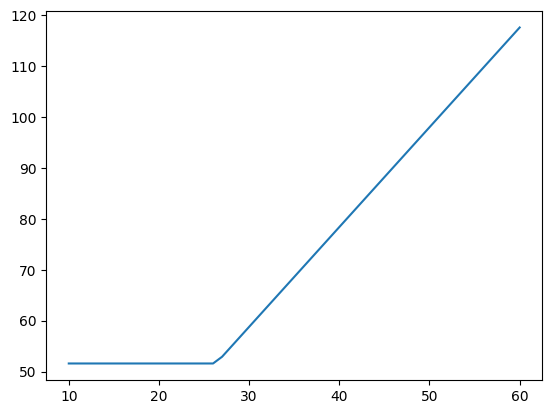

In [91]:
v = np.array([v_1(w, model) for w in w_vals])

plt.plot(w_vals, v)

In [92]:
##### Plots #####

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})


default_model = create_job_search_model()


def fig_dist(model=default_model, fs=10):
    """
    Plot the distribution of wages
    """
    fig, ax = plt.subplots()
    ax.plot(model.w_vals, model.φ, "-o", alpha=0.5, label="wage distribution")
    ax.legend(loc="upper left", fontsize=fs)


def fig_v1(model=default_model, savefig=False,
                  figname="./figures/iid_job_search_0_py.pdf", fs=18):
    """
    Plot two-period value function and res wage
    """
    n, w_vals, φ, β, c = model

    v = [v_1(w, model) for w in w_vals]
    w_star = res_wage(model)
    s = np.maximum(c, w_vals)
    continuation_val = c + β * np.sum(s * φ)
    min_w, max_w = np.min(w_vals), np.max(w_vals)

    fontdict = {'fontsize': 10}
    fig, ax = plt.subplots(figsize=(9, 5.5))
    ax.set_ylim(0, 120)
    ax.set_xlim(min_w, max_w)
    ax.vlines((w_star,), (0,), (continuation_val,), lw=0.5)
    ax.set_yticks((0, 50, 100))
    ax.set_yticklabels((0, 50, 100), fontdict=fontdict)
    ax.set_xticks((min_w, w_star, max_w))
    ax.set_xticklabels((min_w, r"$w^*_1$", max_w), fontdict=fontdict)
    ax.plot(w_vals, w_vals + β * w_vals, alpha=0.8, linewidth=3,
            label=r"$w_1 + \beta w_1$")
    ax.plot(w_vals, [continuation_val]*(n+1), linewidth=3, alpha=0.8,
            label=r"$c + \beta \sum_{w'} \max\{c, w'\} \varphi(w')$" )
    ax.plot(w_vals, v, "k--", markersize=2, alpha=1.0, linewidth=2,
            label=r"$v_1(w_1)$")
    ax.legend(frameon=False, fontsize=fs, loc="upper left")
    if savefig:
        fig.savefig(figname)

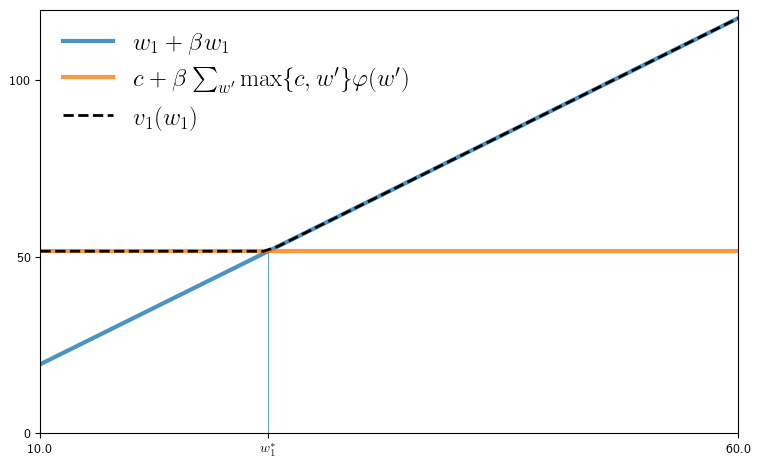

In [93]:
fig_v1()

## Three Period Job Search Model

$$
v_{2}\left(w_{3}\right)=\max\left\{ c,w_{2}\right\}  \\
v_{t}\left(w_{t}\right)=\max\left\{ w_{t}+\sum_{i=1}^{T-t}\beta^{i}w_{t},c+\beta\sum_{w^{\prime}\in W}v_{t+1}\left(w^{\prime}\right)\varphi\left(w^{\prime}\right)\right\} ,\quad t=0,1
$$

In [94]:
# @njit
# def v_1(w, model):
#     """
#     Computes lifetime value at t=1 given current wage w_1 = w
#     """
#     β, c = model.β, model.c
#     s = np.maximum(c, model.w_vals)          # which is v2
#     h_1 = c + β * np.sum(s * model.φ)
#     return np.maximum(w + β * w, h_1)

In [95]:
@njit
def v_t(w, t, v_next, model):
    """
    Computes lifetime value at t given current wage w_t = w and v_{t+1}
    """
    β, c = model.β, model.c
    h_t = c + β * np.sum(v_next * model.φ)
    z_t = w * (β ** np.arange(0, 3-t, 1)).sum()
    return np.maximum(z_t, h_t)

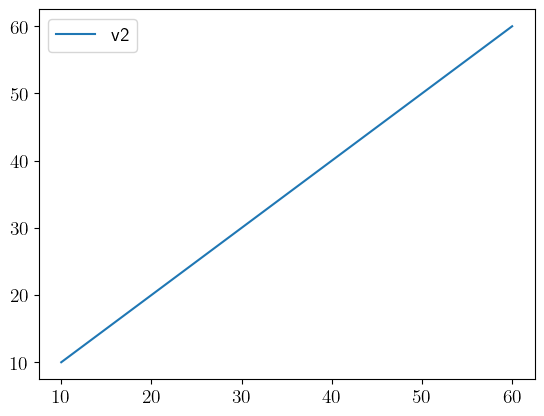

In [96]:
v2 = np.maximum(c, w_vals)

plt.plot(w_vals, v2, label='v2')
plt.legend()

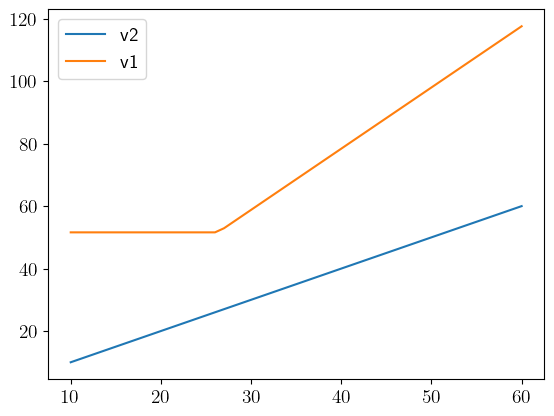

In [97]:
t = 1
v1 = np.array([v_t(w, t, v2, model) for w in w_vals])

plt.plot(w_vals, v2, label='v2')
plt.plot(w_vals, v1, label='v1')
plt.legend()

In [98]:
np.max(np.abs(v1 - v))

1.4210854715202004e-14

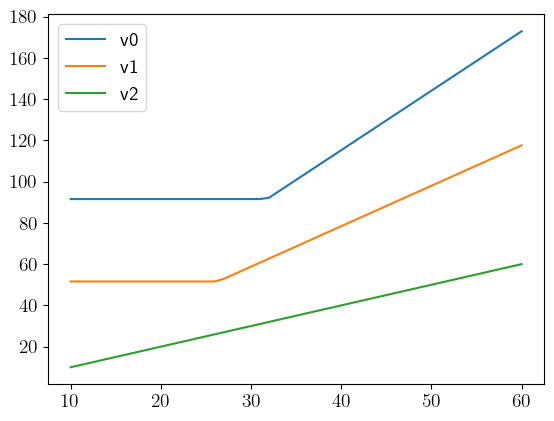

In [99]:
t = 0
v0 = np.array([v_t(w, t, v1, model) for w in w_vals])

plt.plot(w_vals, v0, label='v0')
plt.plot(w_vals, v1, label='v1')
plt.plot(w_vals, v2, label='v2')
plt.legend()

Use array to avoid generating mulptile variable $v_{t}$.

In [100]:
T = 3
v_arr = np.empty((model.w_vals.size, 3))

v_arr.shape

(51, 3)

In [101]:
# v2 = np.maximum(c, w_vals)
v_arr[:, 2] = np.maximum(c, w_vals)

t = 1
v_arr[:, t] = np.array([v_t(w, t, v_arr[:, t+1], model) for w in w_vals])

t = 0
v_arr[:, t] = np.array([v_t(w, t, v_arr[:, t+1], model) for w in w_vals])

In [102]:
np.max(np.abs(v_arr[:, 2] - v2))

0.0

In [103]:
np.max(np.abs(v_arr[:, 1] - v1))

0.0

In [104]:
np.max(np.abs(v_arr[:, 0] - v0))

0.0

# For loops

In [105]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [106]:
for i in range(0, 10, 1):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [107]:
for i in range(9, -1, -1):
    print(i)

9
8
7
6
5
4
3
2
1
0
